In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/kamila/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
# --- 1. Carregamento e Preparação dos Dados ---
print("--- Etapa 1: Carregando e preparando os dados ---")
df = pd.read_csv('dataset_reduzido_renomeadas2.csv')
id_escola_alvo = 21243875

--- Etapa 1: Carregando e preparando os dados ---


In [3]:
# Separar a escola alvo do restante dos dados para o treinamento do modelo
df_alvo = df[df['ID_ESCOLA'] == id_escola_alvo]
df_treino = df[df['ID_ESCOLA'] != id_escola_alvo]

if df_alvo.empty:
    raise ValueError(f"A escola com ID {id_escola_alvo} não foi encontrada no dataset.")

In [4]:
# Preparar os dados de treino
X_train = df_treino.drop(['MEDIA_FINAL', 'ID_ESCOLA'], axis=1)
y_train = df_treino['MEDIA_FINAL']

In [5]:
# Preparar os dados da escola alvo para a predição
X_alvo = df_alvo.drop(['MEDIA_FINAL', 'ID_ESCOLA'], axis=1)
y_alvo_real = df_alvo['MEDIA_FINAL'].iloc[0]

In [6]:
# --- 2. Treinamento do Modelo e Criação do Explainer ---
print("\n--- Etapa 2: Treinando o modelo e calculando SHAP values ---")
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)


--- Etapa 2: Treinando o modelo e calculando SHAP values ---


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [7]:
# O explainer é treinado nos dados de fundo (X_train)
explainer = shap.Explainer(model, X_train)

# Os SHAP values são calculados para a nossa escola de interesse
shap_values_alvo = explainer(X_alvo)

In [8]:
shap_values_train = explainer(X_train)

 96%|=================== | 4436/4606 [00:23<00:00]       

In [9]:
# --- 3. Diagnóstico Individual da Escola 21243875 ---
print(f"\n--- Etapa 3: Diagnóstico da Escola {id_escola_alvo} ---")
print(f"Nota Final Real da Escola: {y_alvo_real:.2f}")
print(f"Nota Final Prevista pelo Modelo: {model.predict(X_alvo)[0]:.2f}")


--- Etapa 3: Diagnóstico da Escola 21243875 ---
Nota Final Real da Escola: 226.32
Nota Final Prevista pelo Modelo: 244.12


In [10]:
# Inicializa o JavaScript para os plots interativos
shap.initjs()

In [11]:
# --- Visualização 1: Gráfico de Forças (Force Plot) ---
print("\n>>> Visualização 1: Gráfico de Forças")
print("Mostra o balanço das forças que aumentam (vermelho) ou diminuem (azul) a nota prevista.")

shap.force_plot(
    explainer.expected_value,
    shap_values_alvo.values[0],
    X_alvo.iloc[0]
)


>>> Visualização 1: Gráfico de Forças
Mostra o balanço das forças que aumentam (vermelho) ou diminuem (azul) a nota prevista.



>>> Visualização 2: Gráfico de Cascata
Detalha a contribuição individual de cada característica, partindo da nota base do modelo.


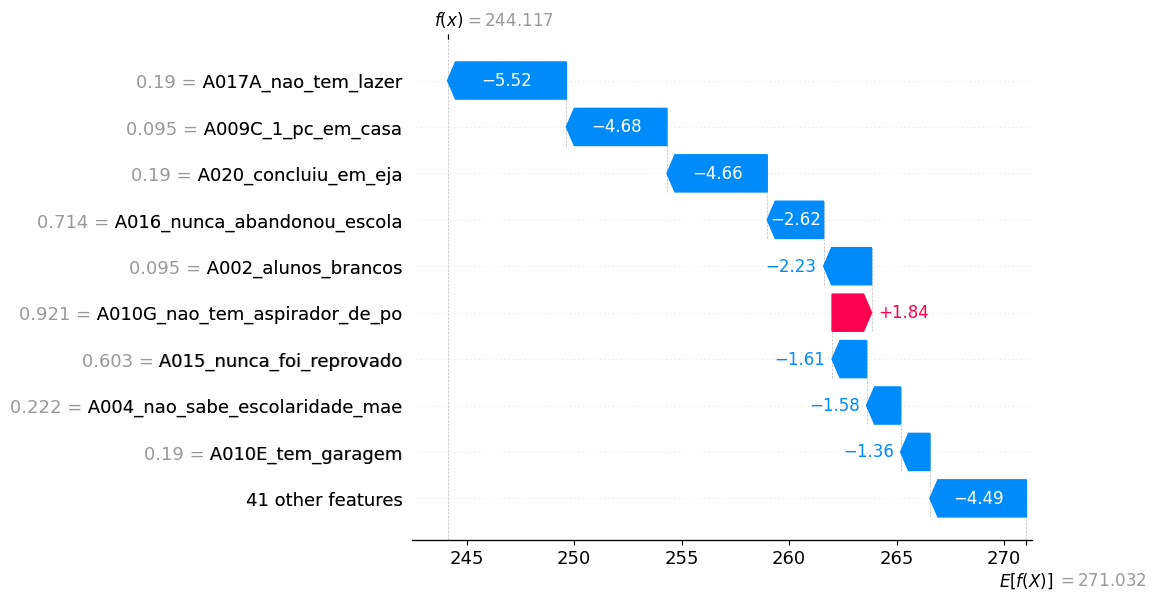

In [12]:
# --- Visualização 2: Gráfico de Cascata (Waterfall Plot) ---
print("\n>>> Visualização 2: Gráfico de Cascata")
print("Detalha a contribuição individual de cada característica, partindo da nota base do modelo.")
shap.waterfall_plot(shap_values_alvo[0])

In [13]:
# --- Visualização 3: Gráficos de Dependência (Dependence Plots) ---
print("\n>>> Visualização 3: Gráficos de Dependência")
print("Mostra como o valor de uma única característica (eixo X) influencia seu impacto na nota (eixo Y) para todas as escolas.")
print("Isso ajuda a entender se existe uma relação linear ou mais complexa.")


>>> Visualização 3: Gráficos de Dependência
Mostra como o valor de uma única característica (eixo X) influencia seu impacto na nota (eixo Y) para todas as escolas.
Isso ajuda a entender se existe uma relação linear ou mais complexa.



Analisando as 3 características mais impactantes para sua escola: A017A_nao_tem_lazer, A009C_1_pc_em_casa, A020_concluiu_em_eja


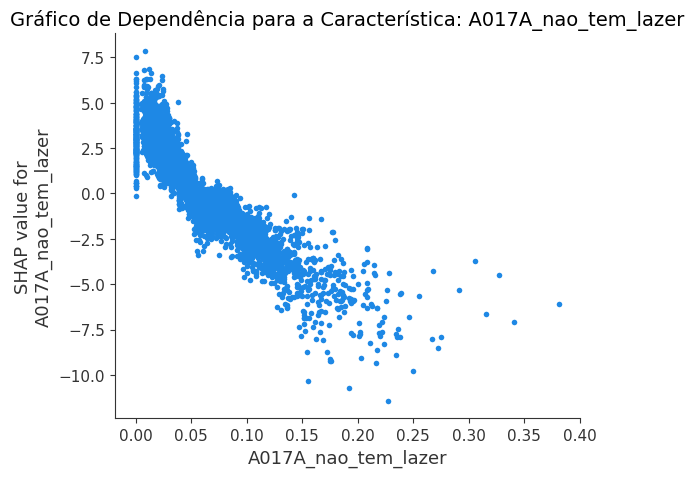

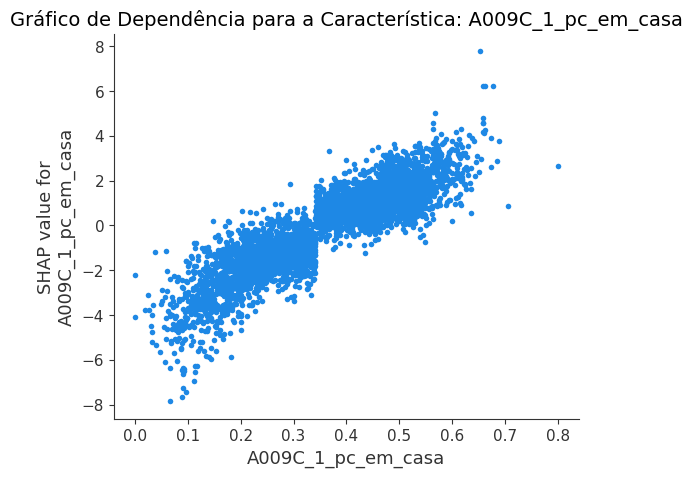

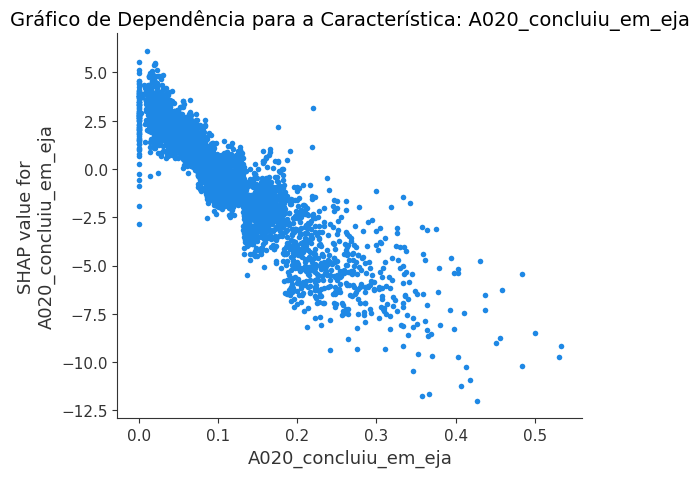

In [14]:
# Identificar as 3 features mais importantes do waterfall plot para explorar
importances = np.abs(shap_values_alvo.values[0])
top_indices = np.argsort(importances)[-3:][::-1]
top_features = X_alvo.columns[top_indices]

print(f"\nAnalisando as 3 características mais impactantes para sua escola: {', '.join(top_features)}")

for feature in top_features:
    shap.dependence_plot(
        feature, 
        shap_values_train.values, # Usa os SHAP values do conjunto de treino para dar contexto
        X_train, # Usa o conjunto de treino como fundo
        interaction_index=None,
        show=False
    )
    plt.title(f'Gráfico de Dependência para a Característica: {feature}', fontsize=14)
    plt.show()


>>> Visualização 4: Importância Geral das Características
Para dar contexto, este gráfico mostra quais características são, em média, as mais importantes no modelo geral.


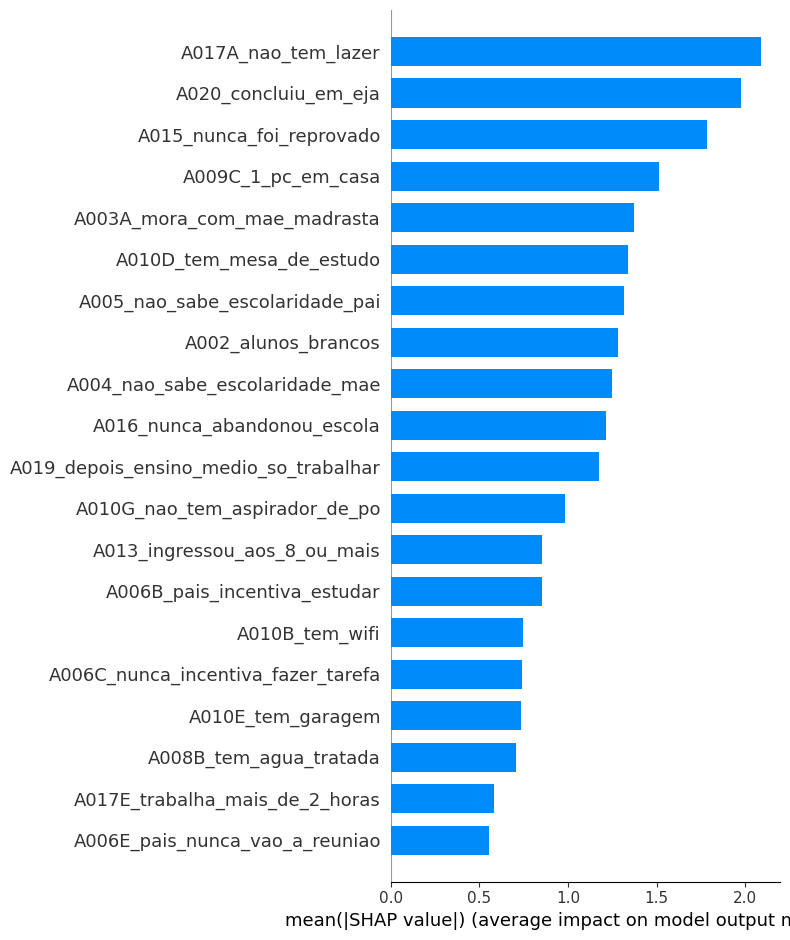

In [15]:
# --- Visualização 4: Contexto Geral (Gráfico de Barras) ---
print("\n>>> Visualização 4: Importância Geral das Características")
print("Para dar contexto, este gráfico mostra quais características são, em média, as mais importantes no modelo geral.")
shap.summary_plot(shap_values_train, X_train, plot_type="bar")